In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_validate
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from scipy import stats

import lightgbm as lgb

In [2]:
def percentage_error(y_true,y_pred):
        epsilon = np.finfo(np.float64).eps
        return (np.average(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true),epsilon)))
        #return mean_absolute_percentage_error(y_true,y_pred) * 100

def rms(y_pred,y_true):
        return np.sqrt(mean_squared_error(y_true,y_pred))
    
def CV_model(model,X,y,N=10,shuffle = True, njobs = -1,error_func = percentage_error,rng = 2021,display = True):
        #importances = []
        cv_est = {'train_score':[],'test_score':[]}
        CV = KFold(n_splits=N,shuffle=shuffle,random_state = rng).split(X)       
        #cv_est = cross_validate(model,X,y,cv = CV,n_jobs=njobs,return_train_score=True,scoring=error_func)
        for train,test in CV:
                X_train,X_test,y_train,y_test = X.iloc[list(train),:],X.iloc[list(test),:],y.iloc[list(train)],y.iloc[list(test)]
                mod = model.fit(X_train,y_train)
                ins = mod.predict(X_train) ## train/in sample
                out = mod.predict(X_test)  ## test/out of sample
                
                #IMP = pd.DataFrame(data = {'Importance' : mod.booster_.feature_importance() , 'Name' : mod.booster_.feature_name() } ).sort_values('Importance',ascending = False)
                #importances.append(IMP)
                
                cv_est['train_score'].append(error_func(y_true = y_train.values,y_pred = ins ))
                cv_est['test_score'].append(error_func(y_true = y_test.values, y_pred = out ))


        err_train,err_test = cv_est['train_score'], cv_est['test_score']
        mean_test,std_test,mean_train,std_train = np.mean(err_test),np.std(err_test),np.mean(err_train),np.std(err_train)

        if display:
                print('\n{} Fold Cross-Validation \nAverage TEST error: {:.3f} \nStd: {:.3f}'.format(N,mean_test,std_test) )
                print('\nAverage TRAIN error: {:.3f} \nStd: {:.3f}'.format(mean_train,std_train) )
        return cv_est,mean_test,mean_train #,importances

# Visualisations

In [3]:
def plot_residuals_overlaid(results,save = True,showlines = True,figsize = (10,5),title_size = 10,markersize = 0.5,suppress_title = True,linewidth = 1,size = 8,fname = 'residuals overlaid.png'):
    time = results.time
    y = results.y_pred

    fig,ax = plt.subplots(figsize = figsize)
    if suppress_title is False:
        plt.suptitle('RSAM forecast with residuals',size = title_size,fontweight='bold')
    
    #ax.plot(time,y, color = 'tab:blue', linewidth = linewidth)
    results.y_pred.plot(color = 'tab:blue', linewidth = linewidth,ax = ax)
    ax.scatter(time,y + results.residuals, color = 'red', marker = 'o',s = markersize) ## overlay the residuals
    
    if showlines:
        ax.vlines(time,y,y + results.residuals,color = 'red',linewidth = linewidth) ## show lines representing the residuals
    
    ax.set_xlabel('Time',size = size)
    ax.set_ylabel('True RSAM',size = size)
    ax.tick_params(axis='both', which='major', labelsize=size)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.xaxis.set_major_locator(plt.MaxNLocator(5)) ## restrict the number of xaxis ticks to
    ax.legend(['Prediction','True Values'])
    ax.yaxis.grid(linestyle = '--')
    #plt.gcf().autofmt_xdate()
    #plt.xticks(rotation=70)

    #formatter = dates.DateFormatter('%Y-%m-%d %H:%M:%S') 
    #plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
    
    if save:
        plt.savefig(fname,bbox_inches = 'tight')
    
    return

def plot_residuals(results,save = True,figsize = (10,5),title_size = 10,size = 5,markersize = 2,alpha = 0.5,fname = 'residual plot png'):
    
    sns.set_style('ticks')
    f,ax = plt.subplots(figsize = figsize)
    ax.set_title('Fitted Residuals', size = title_size )
    r = results.residuals
    #x = results.y_pred
    upper = max(results.y_pred)+100
    low = min(results.y_pred)-100

    results.plot(x= 'y_pred',y = 'residuals',linestyle = 'None', marker = 'o', color = 'tab:blue',markersize = markersize, alpha = alpha,ax = ax)
        #ax[1,0].plot(x,r,linestyle = 'None', marker = 'o', color = 'tab:blue',markersize = markersize, alpha = alpha )
    ax.hlines(y=0, xmin=0, xmax=upper, linewidth=1, color='black',linestyle = '--')
        
    ax.set_xlabel('Predicted RSAM',size = size)
    ax.set_ylabel('Residuals',size = size)
    ax.set_xlim([low,upper])
    ax.get_legend().remove()
    major_ticks = np.arange(-4000, 4001, 500) ## set the intervals for the y-gridlines
    ax.set_yticks(major_ticks)
    #ax[1,0].set_ylim([round(min(r),-2),round(max(r),-2)])
    ax.tick_params(axis='both', which='major', labelsize=size)
    ax.yaxis.grid(linestyle = '--')

    if save:
        plt.savefig(fname)

    return

def prediction_scatter_plot(results,
                            figsize = (10,5),
                            title_size = 10,
                            subtitlesize = 8,
                            size = 5,
                            labelsize = 8,
                            textsize = 5,
                            markersize = 2,
                            hspace = 0.3,
                            wspace = 0.2,
                            alpha = 0.5,
                            xlim = [],
                            ylim = [],
                            save = True,
                            fname ='example_output_signal.png',
                            suppress_title = True):

    f,ax = plt.subplots(figsize = figsize)
    results.plot(x = 'y_pred',y = 'y',linestyle = 'None', marker = 'o', color = 'tab:blue',markersize = markersize, ax = ax, alpha = alpha)
    
    if suppress_title is not True:
        ax.set_title('Predicted and True RSAM Correlation', size = subtitlesize )#, fontweight = 'bold')
        #ax[1].set_title('Fitted Residuals', size = 20, fontweight = 'bold' )
        #plt.plot(x,abline_values, linestyle = '-.', color = 'g')
    
    if ((len(xlim) == 0) and (len(ylim)==0)):
        lower = min(min(results.y_pred),min(results.y))
        upper = max(max(results.y_pred),max(results.y))
        ax.set_xlim([lower,upper])
        ax.set_ylim([lower,upper])
    else:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    
    ax.set_xlabel('Predicted RSAM',size = size)
    ax.set_ylabel('True RSAM',size = size)
    ax.tick_params(axis='both', which='major', labelsize=size)
    ax.get_legend().remove()
    
    major_ticks = np.arange(0, 8500, 500) ## set the intervals for the y-gridlines
    ax.set_yticks(major_ticks)
    ax.set_xticks(major_ticks)
    ax.yaxis.grid(linestyle = '--')
    ax.xaxis.grid(linestyle = '--')

    f.tight_layout(rect=[0, 0.03, 1, 0.95]) # nb rect gives space for title
    plt.subplots_adjust(hspace = hspace,wspace=wspace)
    plt.xticks(fontsize=size)
    plt.yticks(fontsize = size)
        
    if save:
        plt.savefig(fname,bbox_inches = 'tight')
    return

In [4]:
X = pd.read_parquet('X_important.gzip')
y = pd.read_csv('y_aa.csv')
y.set_index('time',inplace = True)

In [5]:
X.head()

rsam|friedrich_coefficients|coeff_3|m_3|r_30__abs_energy  \
time                                                                            
2014-02-12 00:10:00                                       1.157982e-14          
2014-02-12 00:20:00                                       7.535353e-15          
2014-02-12 00:30:00                                       7.153607e-15          
2014-02-12 00:40:00                                       1.243779e-14          
2014-02-12 00:50:00                                       1.009256e-14          

                     rsam|friedrich_coefficients|coeff_0|m_3|r_30__quantile__q_0.6  \
time                                                                                 
2014-02-12 00:10:00                                       5.902560e+10               
2014-02-12 00:20:00                                       6.736478e+10               
2014-02-12 00:30:00                                       4.652752e+10               
2014-02-12 00:40:00                                       5.833734e+10               
2014-02-12 00:50:00                                       7.607121e+10               

                     rsam|max_langevin_fixed_point|m_3|r_30__quantile__q_0.4  \
time                                                                           
2014-02-12 00:10:00                                       2.558494e-07         
2014-02-12 00:20:00                                       1.912787e-07         
2014-02-12 00:30:00                                       1.814393e-07         
2014-02-12 00:40:00                                       2.716742e-07         
2014-02-12 00:50:00                                       2.341690e-07         

                     rsam|quantile|q_0.1__benford_correlation  \
time                                                            
2014-02-12 00:10:00                                  0.705353   
2014-02-12 00:20:00                                  0.861324   
2014-02-12 00:30:00                                  0.924425   
2014-02-12 00:40:00                                  0.681962   
2014-02-12 00:50:00                                  0.736601   

                     rsam|quantile|q_0.8__spkt_welch_density__coeff_8  \
time                                                                    
2014-02-12 00:10:00                                      1.773916e-14   
2014-02-12 00:20:00                                      6.122362e-15   
2014-02-12 00:30:00                                      3.246854e-14   
2014-02-12 00:40:00                                      3.531428e-14   
2014-02-12 00:50:00                                      1.567454e-14   

                     rsam|spkt_welch_density|coeff_5__ar_coefficient__coeff_0__k_10  \
time                                                                                  
2014-02-12 00:10:00                                       1.243127e-12                
2014-02-12 00:20:00                                       4.243944e-13                
2014-02-12 00:30:00                                       4.238078e-13                
2014-02-12 00:40:00                                       7.587900e-13                
2014-02-12 00:50:00                                       9.635028e-13                

                     rsam|median__quantile__q_0.8  rsam|mean_change__maximum  \
time                                                                           
2014-02-12 00:10:00                  1.729779e-08               8.340420e-09   
2014-02-12 00:20:00                  1.861375e-08               8.073743e-09   
2014-02-12 00:30:00                  1.604041e-08               1.218503e-08   
2014-02-12 00:40:00                  2.107725e-08               8.589224e-09   
2014-02-12 00:50:00                  1.802469e-08               9.120990e-09   

                     rsam|quantile|q_0.9__benford_correlation  \
time                                                            
2014-02-12 00:10:00 

In [6]:
print('%f days' % (X.shape[0]/144) )

33.000000 days


In [7]:
YFULL = pd.read_csv('../700 - Research sem 1/WSRZ_tremor_data.csv')[['rsam','time']].set_index('time')
YFULL.index = pd.to_datetime(YFULL.index)
YFULL
#range = pd.date_range("2013","2020",freq="D")

rsam
time                            
2013-05-01 00:00:00  1134.836617
2013-05-01 00:10:00  1144.040015
2013-05-01 00:20:00  1074.544071
2013-05-01 00:30:00  1036.577259
2013-05-01 00:40:00  1093.776018
...                          ...
2020-11-14 23:30:00   312.536976
2020-11-14 23:40:00   341.046449
2020-11-14 23:50:00   321.595185
2020-11-15 00:00:00   302.143920
2020-11-15 00:10:00   295.370190

[396722 rows x 1 columns]

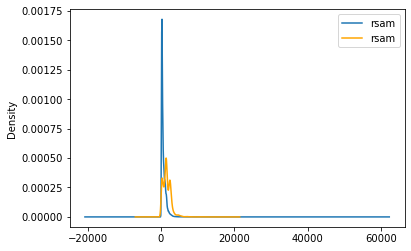

In [8]:
ff,ax = plt.subplots()

YFULL[:'2020-01-01 00:00:00'].plot(kind = 'kde',ax = ax)
y.plot(kind = 'kde',ax = ax,color = 'orange')
plt.show()

## True Target

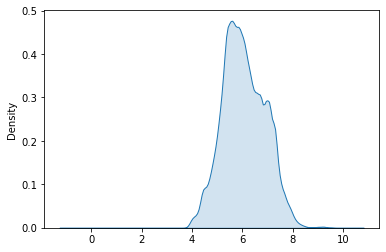

In [9]:
ylog = pd.Series(data = np.log(YFULL.rsam.values))
sns.kdeplot(data = ylog,fill = True,alpha = 0.2)
plt.show()

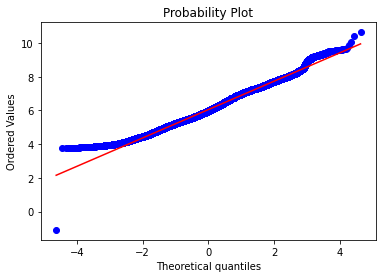

In [10]:
## TRUE DATA
stats.probplot(ylog, plot=sns.mpl.pyplot)
plt.show()

## Training

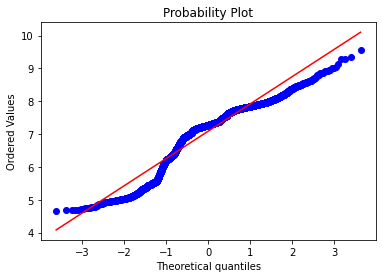

In [11]:
## TRAINING
ytrain_log = pd.Series(data = np.log(y.rsam.values))
stats.probplot(ytrain_log, plot=sns.mpl.pyplot)
plt.show()

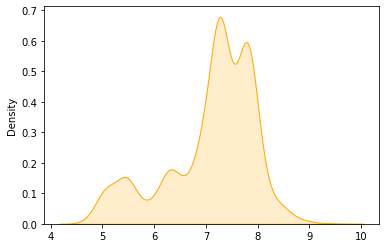

In [12]:
sns.kdeplot(data = ytrain_log,fill = True,alpha = 0.2,color = 'orange')
plt.show()

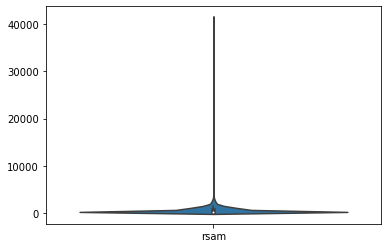

In [13]:
sns.violinplot(data = YFULL)

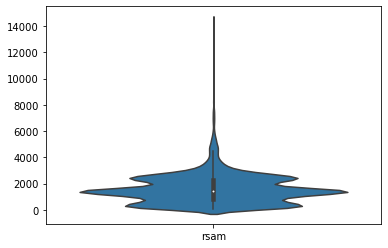

In [14]:
sns.violinplot(data = y)

In [15]:
YFULL.describe()

rsam
count  396722.000000
mean      612.459906
std       670.702843
min         0.338561
25%       230.904816
50%       394.926629
75%       790.799380
max     41483.800466

In [16]:
y.describe()

rsam
count   4752.000000
mean    1608.908877
std     1116.661092
min      104.201039
25%      834.673003
50%     1440.122798
75%     2314.192970
max    14335.778773

In [17]:
tbl = pd.read_csv('FEATURES_info.csv')
tbl.head()

Unnamed: 0                                            feature  p_value  \
0           0  rsam|friedrich_coefficients|coeff_3|m_3|r_30__...      0.0   
1           1  rsam|friedrich_coefficients|coeff_0|m_3|r_30__...      0.0   
2           2  rsam|max_langevin_fixed_point|m_3|r_30__quanti...      0.0   
3           3           rsam|quantile|q_0.1__benford_correlation      0.0   
4           4   rsam|quantile|q_0.8__spkt_welch_density__coeff_8      0.0   

   correlation  Importance  
0     0.399388           1  
1     0.000000           1  
2     0.772774           2  
3     0.390822           3  
4     0.266026           2

In [18]:
corr_sorted = tbl.sort_values('correlation',ascending = False)
corr_sorted.head()

Unnamed: 0                                            feature  p_value  \
44          44   rsam|spkt_welch_density|coeff_5__quantile__q_0.3      0.0   
2            2  rsam|max_langevin_fixed_point|m_3|r_30__quanti...      0.0   
48          48            rsam|spkt_welch_density|coeff_5__median      0.0   
43          43   rsam|spkt_welch_density|coeff_5__quantile__q_0.2      0.0   
5            5  rsam|spkt_welch_density|coeff_5__ar_coefficien...      0.0   

    correlation  Importance  
44     0.785007           2  
2      0.772774           2  
48     0.770532           1  
43     0.764153           1  
5      0.729193           9

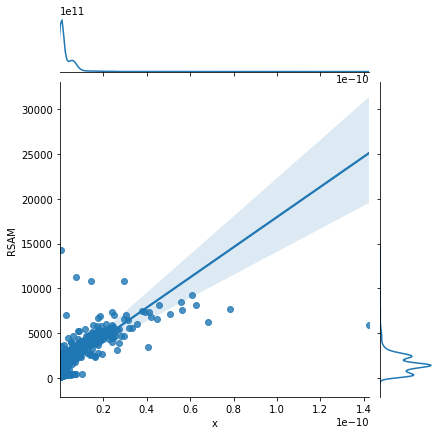

In [19]:
name = corr_sorted.feature.iloc[2]
df = pd.DataFrame()
df['RSAM'] = y
df['x'] = X[name]

#plt.xlabel(name)
#plt.ylabel('RSAM')
g = sns.JointGrid(data=df, x="x", y="RSAM")
g.plot(sns.regplot,sns.kdeplot)
plt.show()

#fig,ax = plt.subplots(figsize = (20,10))
#sns.regplot(data =df ,x = 'x',y = 'y')
#ax.set_xlabel(name)

In [20]:
IMP = tbl.sort_values('Importance',ascending = False)
IMP

Unnamed: 0                                            feature  \
63           63           rsam|quantile|q_0.7__benford_correlation   
21           21  rsam|ar_coefficient|coeff_0|k_10__absolute_sum...   
77           77  rsam|first_location_of_maximum__permutation_en...   
104         104  rsam|ar_coefficient|coeff_1|k_10__ar_coefficie...   
20           20  rsam|ar_coefficient|coeff_0|k_10__cid_ce__norm...   
..          ...                                                ...   
59           59       rsam|abs_energy__spkt_welch_density__coeff_2   
57           57       rsam|abs_energy__spkt_welch_density__coeff_8   
55           55   rsam|spkt_welch_density|coeff_2__quantile__q_0.6   
54           54  rsam|spkt_welch_density|coeff_2__friedrich_coe...   
78           78  rsam|quantile|q_0.8__ar_coefficient__coeff_2__...   

           p_value  correlation  Importance  
63   3.793226e-260     0.000000          38  
21    0.000000e+00     0.487427          20  
77    1.244730e-58     0.000000          15  
104   3.621100e-20     0.000000          10  
20    0.000000e+00     0.298217          10  
..             ...          ...         ...  
59    0.000000e+00     0.031602           1  
57    0.000000e+00     0.047147           1  
55    0.000000e+00     0.451588           1  
54    0.000000e+00     0.497831           1  
78    5.736884e-58     0.241114           1  

[156 rows x 5 columns]

In [21]:
[print(f) for f in IMP.feature.iloc[0:5]]

rsam|quantile|q_0.7__benford_correlation
rsam|ar_coefficient|coeff_0|k_10__absolute_sum_of_changes
rsam|first_location_of_maximum__permutation_entropy__dimension_3__tau_1
rsam|ar_coefficient|coeff_1|k_10__ar_coefficient__coeff_1__k_10
rsam|ar_coefficient|coeff_0|k_10__cid_ce__normalize_False


[None, None, None, None, None]

## Top Important Feature

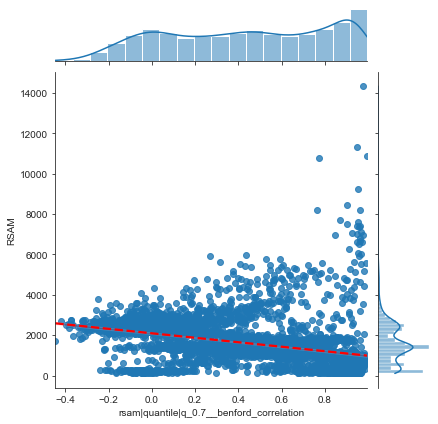

In [22]:
## x-y scatter
name = IMP.feature.iloc[0]
df = pd.DataFrame()
df['RSAM'] = y #np.log(y)
df['rsam|quantile|q_0.7__benford_correlation']  = X[name] #np.log(X[name])

#f,ax = plt.subplots()
sns.set_style('ticks')
sns.jointplot(data=df, x="rsam|quantile|q_0.7__benford_correlation", y="RSAM",kind = 'reg',line_kws={"color": "red",'linestyle' : '--'})
#ax.set_xlabel(name)
plt.savefig('Top_important_feature',bbox_inches = 'tight')
plt.show()

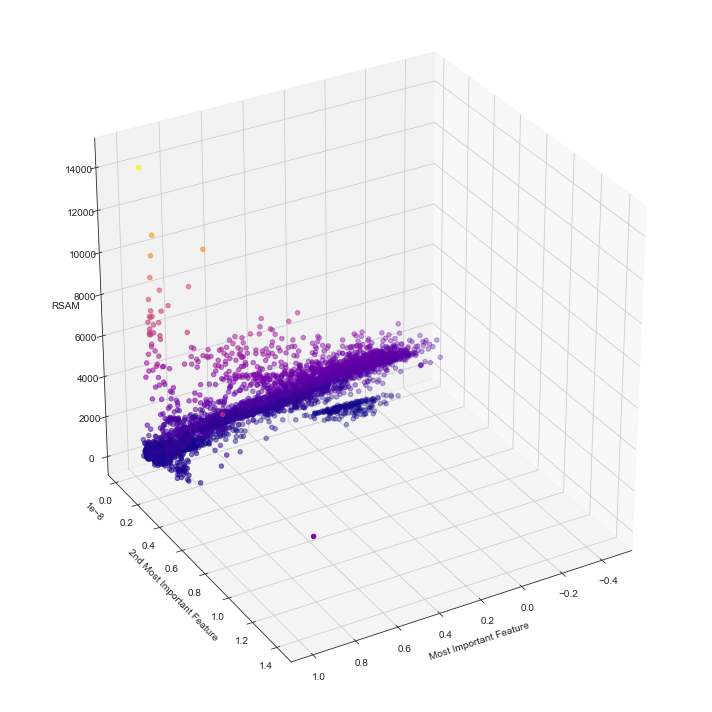

In [23]:
#%matplotlib notebook
#from mpl_toolkits.mplot3d import axes3d 

ff,ax = plt.subplots(figsize = (10,10))
ax = plt.axes(projection='3d')

name1 = IMP.feature.iloc[0]
name2 = IMP.feature.iloc[1]

xdata = X[name1].values
ydata = X[name2].values
zdata = y.values

# Data for a three-dimensional line
#zline = y.values
#xline = np.linspace(0,max())
#yline = X[IMP.feature.iloc[1]].values
#ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
ax.scatter3D(xdata, ydata, zdata, c=zdata,cmap='plasma')#, cmap='Greens')
ax.set_xlabel('Most Important Feature',linespacing=5)
ax.set_ylabel('2nd Most Important Feature',linespacing=5)
ax.set_zlabel('RSAM',linespacing=5)
ax.xaxis._axinfo['label']['space_factor'] = 5
ax.yaxis._axinfo['label']['space_factor'] = 5
ax.zaxis._axinfo['label']['space_factor'] = 5

ax.azim = 60
ax.elev = 30
plt.tight_layout()
plt.savefig('3d')

In [ ]:
sns.set_style('whitegrid',{"grid.linestyle": ":"})
g = sns.jointplot(data=df, x="rsam|quantile|q_0.7__benford_correlation", y="RSAM",kind = 'kde',levels = 20,cmap = 'viridis',fill = False)#,ax = g.ax_joint)
#sns.regplot(data=df, x="x", y="RSAM",line_kws = {'color':'red','linestyle':'--'},ax = g.ax_joint)
g.set_axis_labels(name, 'RSAM')#, fontsize=16)
#g.plot_joint(sns.regplot, line_kws = {'color':'red','linestyle':'--',},scatter_kws={'s':0})
#plt.savefig('Density_plot_top_feature')
plt.show()


In [ ]:
sns.set_style('whitegrid',{"grid.linestyle": ":"})
g = sns.regplot(data=df, x="rsam|quantile|q_0.7__benford_correlation", y="RSAM",)
#sns.regplot(data=df, x="x", y="RSAM",line_kws = {'color':'red','linestyle':'--'},ax = g.ax_joint)
g.set_axis_labels(name, 'RSAM')#, fontsize=16)
#g.plot_joint(sns.regplot, line_kws = {'color':'red','linestyle':'--',},scatter_kws={'s':0})
#plt.savefig('Density_plot_top_feature')
plt.show()

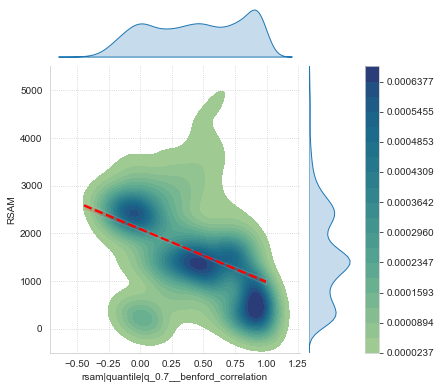

In [65]:
sns.set_style('whitegrid',{"grid.linestyle": ":"})
g = sns.jointplot(data=df, 
                  x="rsam|quantile|q_0.7__benford_correlation", 
                  y="RSAM",
                  kind = 'kde',
                  levels = 20,
                  cmap = 'crest',
                  fill = True, #True,
                  cbar = True,
                 ylim = [-500,5500] )#,ax = g.ax_joint)

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
g.set_axis_labels(name, 'RSAM')#, fontsize=16)
g.plot_joint(sns.regplot, 
             line_kws = {'color':'red','linestyle':'--',},
             scatter_kws={'s':0}) #,'color':'blue'})

pos_joint_ax = g.ax_joint.get_position()
pos_marg_x_ax = g.ax_marg_x.get_position()
g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height]) # reposition the joint ax so it has the same width as the marginal x ax
g.fig.axes[-1].set_position([.83, pos_joint_ax.y0, 1, pos_joint_ax.height]) # reposition the colorbar using new x positions and y positions of the joint ax
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

#g.fig.axes.set_ylim([0, 6000])

#plt.tight_layout()
#plt.savefig('Density_plot_top_feature_IMPROVED')
plt.show()


## Pairplot

In [28]:
## x-y scatter
#names = list(IMP.feature.iloc[:3])
##dd = X[names]
##dd.insert(0,'RSAM',y.rsam)
##sns.pairplot(dd, height=5,corner = True, diag_kind = 'kde')
##plt.show()

## Second Important Feature

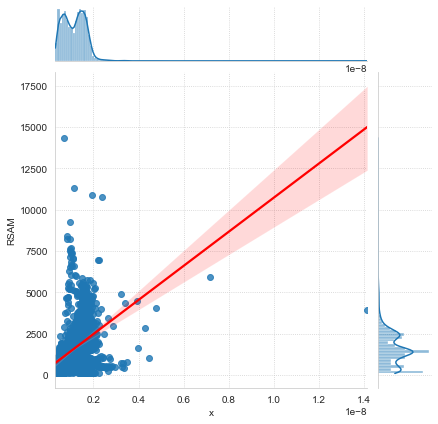

In [29]:
## x-y scatter
name = IMP.feature.iloc[1]
df = pd.DataFrame()
df['RSAM'] = y #np.log(y)
df['x']  = X[name] #np.log(X[name])

#f,ax = plt.subplots()
sns.jointplot(data=df, x="x", y="RSAM",kind = 'reg',line_kws={"color": "red"})
#ax.set_xlabel(name)
plt.show()

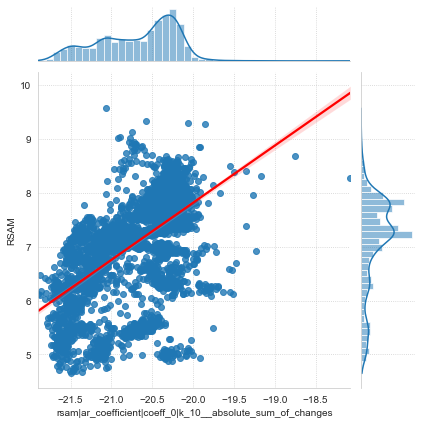

In [30]:
## log-log plot
name = IMP.feature.iloc[1]
df = pd.DataFrame()
df['RSAM'] = np.log(y) #np.log(y)
df["rsam|ar_coefficient|coeff_0|k_10__absolute_sum_of_changes"]  = np.log(X[name]) #np.log(X[name])

#f,ax = plt.subplots()
ax = sns.jointplot(data=df, x="rsam|ar_coefficient|coeff_0|k_10__absolute_sum_of_changes", y="RSAM",kind = 'reg',line_kws={"color": "red"})
#ax.set_xlabel(name)
plt.show()

## 3rd Important Feature

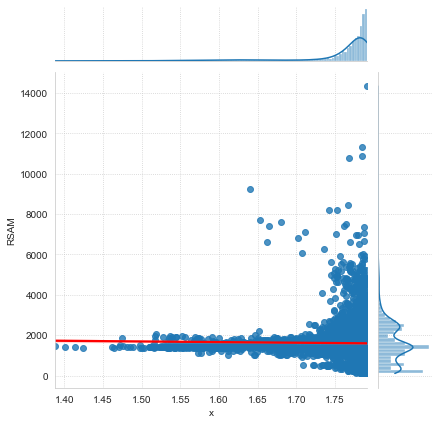

In [31]:
## x-y scatter
name = IMP.feature.iloc[2]
df = pd.DataFrame()
df['RSAM'] = y #np.log(y)
df['x']  = X[name] #np.log(X[name])

#f,ax = plt.subplots()
sns.jointplot(data=df, x="x", y="RSAM",kind = 'reg',line_kws={"color": "red"})
#ax.set_xlabel(name)
plt.show()

## Feature Important 4

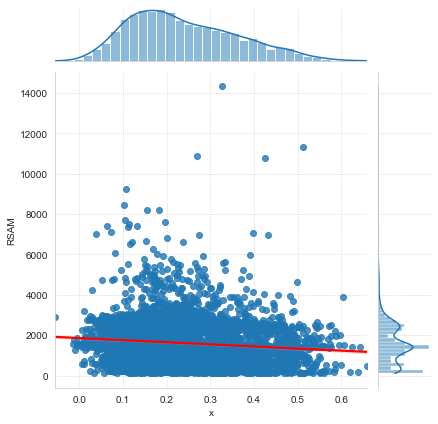

In [32]:
## x-y scatter
name = IMP.feature.iloc[3]
df = pd.DataFrame()
df['RSAM'] = y #np.log(y)
df['x']  = X[name] #np.log(X[name])

#f,ax = plt.subplots()
sns.jointplot(data=df, x="x", y="RSAM",kind = 'reg',line_kws={"color": "red"})
#ax.set_xlabel(name)
plt.show()

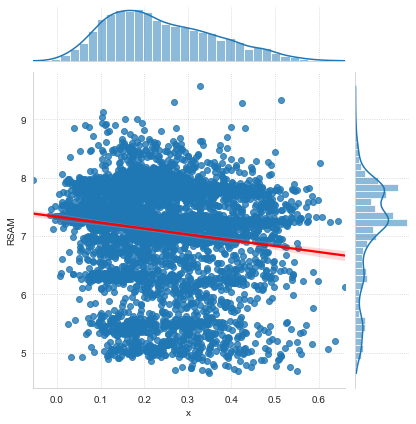

In [33]:
## x-log(y) scatter
name = IMP.feature.iloc[3]
df = pd.DataFrame()
df['RSAM'] = np.log(y)
df['x']  = X[name] #np.log(X[name])

#f,ax = plt.subplots()
sns.jointplot(data=df, x="x", y="RSAM",kind = 'reg',line_kws={"color": "red"})
#ax.set_xlabel(name)
plt.show()

# Features by Correlation

In [34]:
corr_sorted.iloc[:3,:]

Unnamed: 0                                            feature  p_value  \
44          44   rsam|spkt_welch_density|coeff_5__quantile__q_0.3      0.0   
2            2  rsam|max_langevin_fixed_point|m_3|r_30__quanti...      0.0   
48          48            rsam|spkt_welch_density|coeff_5__median      0.0   

    correlation  Importance  
44     0.785007           2  
2      0.772774           2  
48     0.770532           1

## Top Features

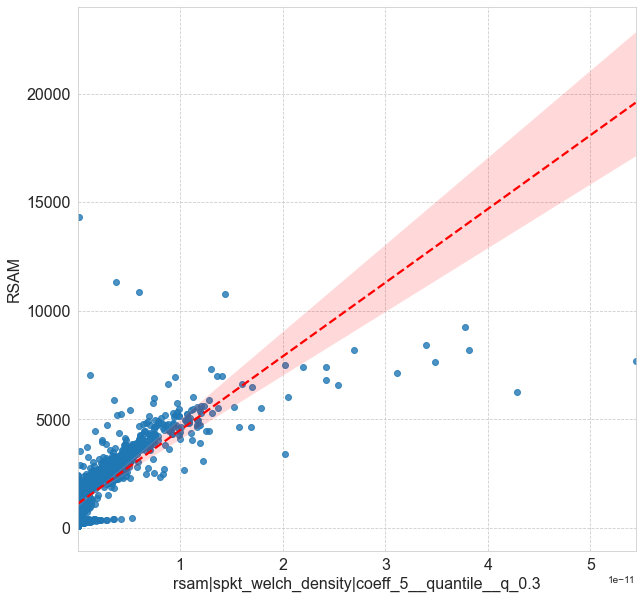

In [35]:
## x-y scatter
name = corr_sorted.feature.iloc[0]
df = pd.DataFrame()
df['RSAM'] = y #np.log(y)
df['x']  = X[name] #np.log(X[name])

f,ax = plt.subplots(figsize = (10,10))
sns.regplot(data=df, x="x", y="RSAM",line_kws={"color": "red", 'linestyle':'--'},ax = ax)
ax.set_xlabel(name,size =16)
ax.set_ylabel('RSAM',size = 16)
plt.xticks(size = 16)
plt.yticks(size = 16)
ax.yaxis.grid(linestyle = '--')
ax.xaxis.grid(linestyle = '--')
plt.savefig('top_feature_by_corr')
plt.show()

## 2nd Feature

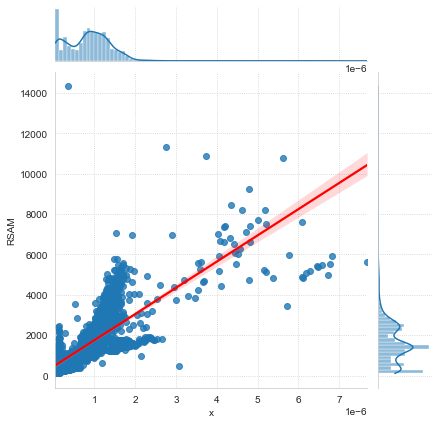

In [36]:
## x-y scatter
name = corr_sorted.feature.iloc[1]
df = pd.DataFrame()
df['RSAM'] = y #np.log(y)
df['x']  = X[name]

#f,ax = plt.subplots()
sns.jointplot(data=df, x="x", y="RSAM",kind = 'reg',line_kws={"color": "red"})
#ax.set_xlabel(name)
plt.show()

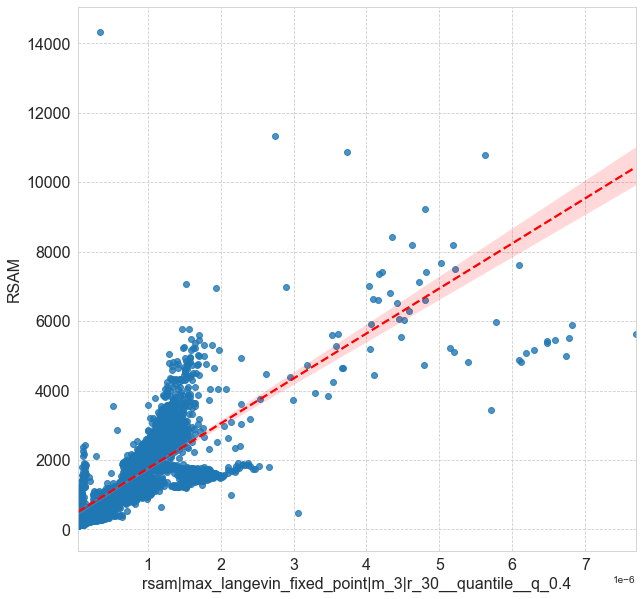

In [37]:
f,ax = plt.subplots(figsize = (10,10))
sns.regplot(data=df, x="x", y="RSAM",line_kws={"color": "red", 'linestyle':'--'},ax = ax)
ax.set_xlabel(name,size =16)
ax.set_ylabel('RSAM',size = 16)
plt.xticks(size = 16)
plt.yticks(size = 16)
ax.yaxis.grid(linestyle = '--')
ax.xaxis.grid(linestyle = '--')
plt.show()

## 3rd Feature

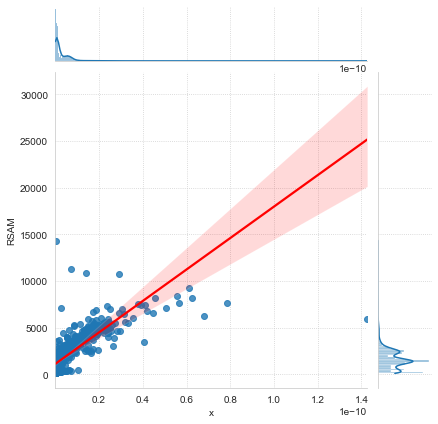

In [38]:
## x-y scatter
name = corr_sorted.feature.iloc[2]
df = pd.DataFrame()
df['RSAM'] = y #np.log(y)
df['x']  = X[name] #np.log(X[name])

#f,ax = plt.subplots()
sns.jointplot(data=df, x="x", y="RSAM",kind = 'reg',line_kws={"color": "red"})
#ax.set_xlabel(name)
plt.show()

## 4th Feature

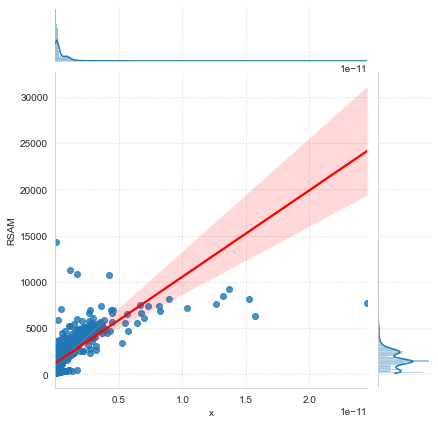

In [39]:
## x-y scatter
name = corr_sorted.feature.iloc[5]
df = pd.DataFrame()
df['RSAM'] = y #np.log(y)
df['x']  = X[name] #np.log(X[name])

#f,ax = plt.subplots()
sns.jointplot(data=df, x="x", y="RSAM",kind = 'reg',line_kws={"color": "red"})
#ax.set_xlabel(name)
plt.show()

# Evaluate Performance

In [40]:
#mod = lgb.Booster(model_file = 'MODEL.mod')
mod = lgb.LGBMRegressor()

### Cross-Validated Mean Average Percentage Error, Root Mean Square Error, and R2 score respectively

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 2021)

In [43]:
#X1 = X.reset_index()
#y1 = y.reset_index()
score = CV_model(mod,X_train,y_train,N=10,shuffle = True, njobs = -1,error_func = percentage_error,rng = 2021,display = True)
print(score[:2])


10 Fold Cross-Validation 
Average TEST error: 1.621 
Std: 0.092

Average TRAIN error: 1.627 
Std: 0.011
({'train_score': [1.6402396384526934, 1.6294368014490992, 1.6272730370720339, 1.6364109548812702, 1.6228973223890615, 1.633863094907276, 1.6224415418168114, 1.6184626247997371, 1.6358698753864578, 1.6020230085179317], 'test_score': [1.4958889044256989, 1.6511710137248319, 1.5750042309964476, 1.5428239789040188, 1.67615473911063, 1.575507889515714, 1.6811570533316043, 1.688892194196851, 1.5119904394912276, 1.8066653515553506]}, 1.6205255795252373)


In [45]:
score1 = CV_model(mod,X_train,y_train,N=10,shuffle = True, njobs = -1,error_func = rms,rng = 2021,display = True)
print(score1)


10 Fold Cross-Validation 
Average TEST error: 364.430 
Std: 158.048

Average TRAIN error: 169.931 
Std: 17.296
({'train_score': [172.76994936298718, 175.18941801496584, 167.01133039703421, 182.2073836170813, 173.95614609433267, 177.12694635881522, 177.4621320837896, 172.0339862424509, 181.86508049156384, 119.68306992906129], 'test_score': [435.9604137812242, 322.4806699577282, 469.82396320502903, 187.356450889695, 280.3165988694892, 232.16203864903846, 341.72509394925004, 380.6337773848465, 232.34911110656824, 761.4927714792187]}, 364.4300889272087, 169.93054425920818)


In [46]:
score2 =  CV_model(mod,X_train,y_train,N=10,shuffle = True, njobs = -1,error_func = r2_score,rng = 2021,display = True)
print(score2)


10 Fold Cross-Validation 
Average TEST error: 0.885 
Std: 0.091

Average TRAIN error: 0.977 
Std: 0.004
({'train_score': [0.9759932459780489, 0.9759658647125733, 0.9778184727076826, 0.9742290938898975, 0.9765427859527106, 0.9755465219224377, 0.9755301674062282, 0.9767037393027118, 0.9741220550771531, 0.9883978038474199], 'test_score': [0.8740503182667474, 0.914463354881626, 0.8411281649453937, 0.9685358092267734, 0.9283126026563224, 0.9536259552558408, 0.8950455603150026, 0.886060015868945, 0.955088601168048, 0.6372723253525614]}, 0.8853582707937262, 0.9770849750796863)


In [47]:
fit = mod.fit(X_train,y_train)
yhat = fit.predict(X_test)
results = pd.DataFrame(data = {'y':y_test.rsam.values,'y_pred':yhat,'residuals':y_test.rsam.values-yhat,'time' : y_test.index})

In [48]:
results

y       y_pred   residuals                 time
0     2622.408401  2465.785958  156.622443  2019-11-28 06:40:00
1     2250.452314  2312.103534  -61.651220  2019-12-04 11:40:00
2      243.507357   253.118799   -9.611442  2016-10-14 04:50:00
3     2058.430391  2122.639799  -64.209408  2019-11-29 02:50:00
4     1860.550023  1806.390829   54.159195  2019-11-22 19:20:00
...           ...          ...         ...                  ...
1183  2689.485129  2588.664766  100.820363  2019-12-01 21:50:00
1184   214.908395   238.359557  -23.451162  2018-03-09 23:00:00
1185  2308.354700  2578.717079 -270.362379  2019-12-04 22:00:00
1186  2760.913478  2789.349061  -28.435583  2019-11-28 06:20:00
1187  1564.726662  1398.379671  166.346991  2019-11-08 03:00:00

[1188 rows x 4 columns]

In [49]:
100*percentage_error(y_test.rsam,yhat)

10.969349594815899

In [50]:
r2_score(y_test.rsam,yhat)

0.9262267698751705

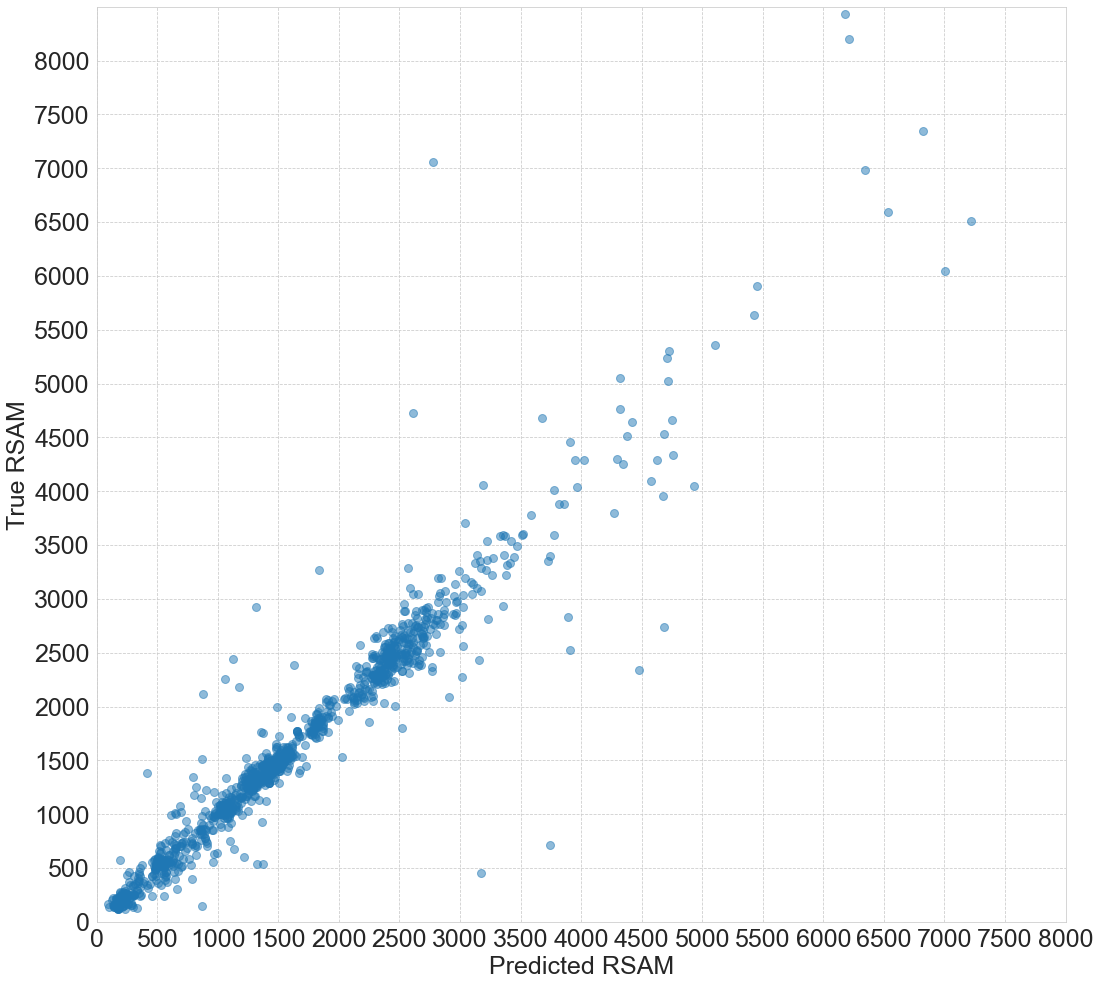

In [51]:
prediction_scatter_plot(results,figsize = (15,15),size=25,markersize=8)
ax = plt.gca()
ax.set_xlim([0,8000])
ax.set_ylim([0,8500])
plt.savefig('BEST_model_predictions',bbox_inches = 'tight')
plt.show()

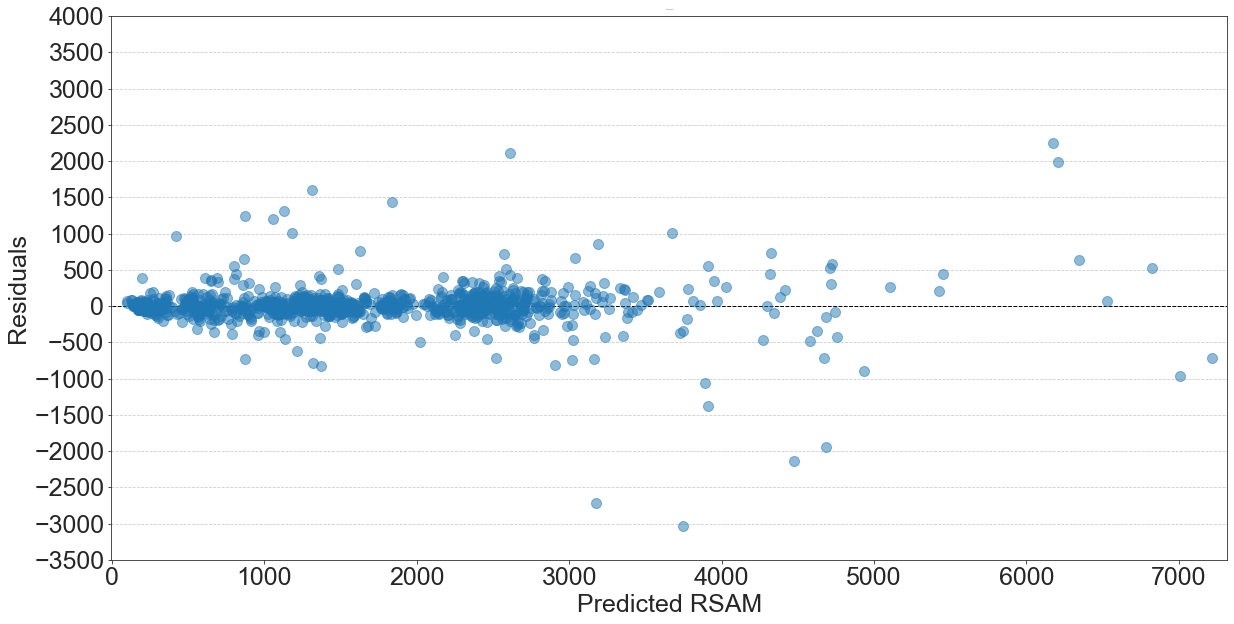

In [52]:
results.residuals
plot_residuals(results,figsize = (20,10),size=25,title_size=0,markersize = 10,)
ax = plt.gca()
ax.set_ylim([-3500,4000])
plt.savefig('BEST_residuals',bbox_inches = "tight")
plt.show()

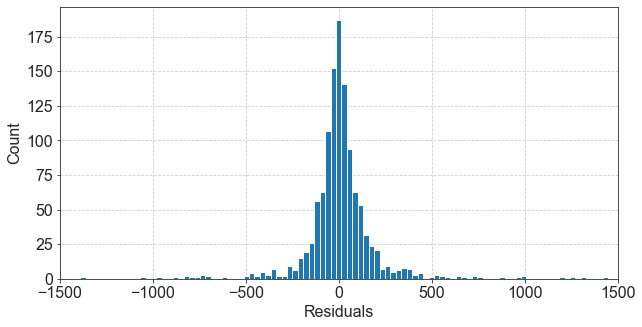

In [53]:
fg,axes = plt.subplots(figsize = (10,5))
results.residuals.hist(bins = 250,ax = axes,color = 'tab:blue')
axes.set_xlim([-1500,1500])
axes.set_xlabel('Residuals',size = 16)
axes.set_ylabel('Count',size = 16)
plt.xticks(size = 16)
plt.yticks(size = 16)
axes.yaxis.grid(linestyle = '--')
axes.xaxis.grid(linestyle = '--')
plt.show()

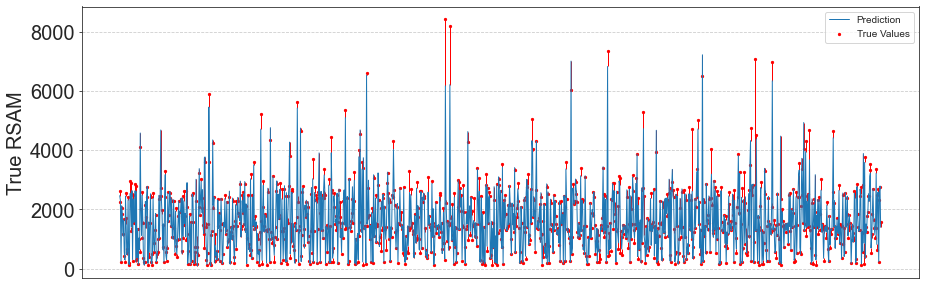

In [54]:
plot_residuals_overlaid(results,figsize = (15,5),size=20,markersize=5)
p = plt.gca()
p.axes.xaxis.set_ticklabels([]) # Remove labels
p.axes.get_xaxis().set_visible(False)
plt.savefig('Best_Residuals_overlaid',bbox_inches = 'tight')
plt.show()

In [55]:
tree_df = fit.booster_.trees_to_dataframe()

In [56]:
tree_df.sort_values('split_gain',ascending = False)

tree_index  node_depth node_index left_child right_child parent_index  \
0              0           1       0-S0       0-S2        0-S1         None   
61             1           1       1-S0       1-S2        1-S1         None   
122            2           1       2-S0       2-S2        2-S1         None   
183            3           1       3-S0       3-S2        3-S1         None   
244            4           1       4-S0       4-S2        4-S1         None   
...          ...         ...        ...        ...         ...          ...   
6095          99           7      99-L7       None        None        99-S6   
6096          99           6      99-L5       None        None        99-S4   
6097          99           4      99-L3       None        None        99-S2   
6098          99           3      99-L2       None        None        99-S1   
6099          99           2      99-L1       None        None        99-S0   

                                          split_feature    split_gain  \
0     rsam|spkt_welch_density|coeff_5__cid_ce__norma...  2.455930e+09   
61    rsam|spkt_welch_density|coeff_5__cid_ce__norma...  1.989310e+09   
122   rsam|spkt_welch_density|coeff_5__cid_ce__norma...  1.611620e+09   
183   rsam|spkt_welch_density|coeff_5__cid_ce__norma...  1.305420e+09   
244   rsam|spkt_welch_density|coeff_5__cid_ce__norma...  1.057390e+09   
...                                                 ...           ...   
6095                                               None           NaN   
6096                                               None           NaN   
6097                                               None           NaN   
6098                                               None           NaN   
6099                                               None           NaN   

         threshold decision_type missing_direction missing_type        value  \
0     1.200133e-10            <=              left         None  1608.090000   
61    1.200133e-10            <=              left         None     0.000000   
122   1.164447e-10            <=              left         None     0.000000   
183   1.164447e-10            <=              left         None     0.000000   
244   1.164447e-10            <=              left         None     0.000000   
...            ...           ...               ...          ...          ...   
6095           NaN          None              None         None    11.190780   
6096           NaN          None              None         None   -27.362943   
6097           NaN          None              None         None    16.753889   
6098           NaN          None              None         None   -18.131777   
6099           NaN          None              None         None    21.449320   

      weight  count  
0          0   3564  
61         0   3564  
122        0   3564  
183        0   3564  
244        0   3564  
...      ...    ...  
6095      25     25  
6096      21     21  
6097      20     20  
6098      27     27  
6099      28     28  

[6100 rows x 15 columns]

In [ ]:
#IMP

In [57]:
#tbl  = pd.DataFrame(data = {'Importance' : fit.booster_.feature_importance() ,  'Name' : fit.booster_.feature_name() } ).sort_values('Importance',ascending = False)
#tbl

Importance                                               Name
63           74           rsam|quantile|q_0.7__benford_correlation
10           70  rsam|spkt_welch_density|coeff_5__cid_ce__norma...
77           56  rsam|first_location_of_maximum__permutation_en...
9            54            rsam|quantile|q_0.9__standard_deviation
49           52           rsam|spkt_welch_density|coeff_5__maximum
..          ...                                                ...
126           4  rsam|ar_coefficient|coeff_3|k_10__ar_coefficie...
28            3        rsam|ar_coefficient|coeff_1|k_10__c3__lag_2
13            3  rsam|ar_coefficient|coeff_3|k_10__quantile__q_0.2
27            3           rsam|ar_coefficient|coeff_1|k_10__median
12            1        rsam|ar_coefficient|coeff_3|k_10__c3__lag_3

[156 rows x 2 columns]